# Phase 2: Hierarchical + Day-of-Week Stitching Method

This notebook implements the hierarchical stitching method with day-of-week (DOW) pattern correction.

**Method**: Hierarchical + Day-of-Week Correction

**Algorithm**:
1. Run base hierarchical stitching
2. Estimate day-of-week pattern from weekly data
3. Apply DOW correction multiplicatively
4. **[FIXED]** Skip renormalization to preserve hierarchical optimization

**Use Case**: Search terms with strong weekly patterns (e.g., weekend spikes, weekday patterns)

**Expected Performance**: Similar or slightly better than hierarchical, with weekly seasonality patterns preserved.

**Outputs**:
- `interim/hierarchical_dow/stitched_series.parquet`
- `interim/hierarchical_dow/alpha_estimates.pkl`
- `interim/hierarchical_dow/diagnostics.pkl`


## 0. Setup

In [2]:
# Setup
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

from config import ConfigManager
from utils import FileManager, setup_logger
from stitching import HierarchicalDOWStitcher, HierarchicalStitcher, StitchingResult

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


In [4]:
# Load configuration
config = ConfigManager(
    config_path=project_root / "config.yaml",
    env_path=project_root / ".env"
)
file_manager = FileManager(project_root)
file_manager.ensure_directories()

# Setup logging
log_file = file_manager.get_log_path("hierarchical_dow_stitching.log")
setup_logger(log_file, level="INFO")

print(config.summary())

2025-11-12 23:49:43.247 | INFO     | config:__init__:221 - Loaded environment variables from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/.env
2025-11-12 23:49:43.252 | INFO     | config:__init__:232 - Loaded configuration from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/config.yaml
2025-11-12 23:49:43.253 | SUCCESS  | config:_parse_config:319 - Configuration validated successfully
2025-11-12 23:49:43.254 | INFO     | utils:ensure_directories:50 - Ensured all directories exist under /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing
2025-11-12 23:49:43 | INFO     | Logging to file: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/logs/hierarchical_dow_stitching.log


Configuration Summary
Search Term: flu vaccine
Geographic Location: GB
Date Range: 2022-01-01 to 2024-12-31 (1096 days)
Overlap: 60 days
Random Seed: 42

Stitching Weights:
  Monthly: 1.0
  Weekly: 0.5
  Overlap: 0.1

Zero Handling:
  Threshold: 0.01
  Structural Zero Months: [6, 7, 8]

Optimization:
  Max Iterations: 1000
  Tolerance: 1e-08

SerpAPI:
  Timeout: 90s
  Max Retries: 3
  Retry Delay: 10s


## 1. Load Data

Load the data collected in Phase 1.

In [5]:
# Load monthly data
monthly_path = file_manager.get_raw_data_path("monthly")
if not monthly_path.exists():
    raise FileNotFoundError(
        f"Monthly data not found at {monthly_path}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

monthly_data = pd.read_parquet(monthly_path)
print(f"Loaded monthly data: {len(monthly_data)} months")
print(f"Date range: {monthly_data['date'].min()} to {monthly_data['date'].max()}")
monthly_data.head()

Loaded monthly data: 263 months
Date range: 2004-01-01 00:00:00 to 2025-11-01 00:00:00


,date,value,is_partial
0,2004-01-01,2,False
1,2004-02-01,2,False
2,2004-03-01,1,False
3,2004-04-01,1,False
4,2004-05-01,0,False


In [6]:
# Load weekly data (REQUIRED for DOW correction)
weekly_path = file_manager.get_raw_data_path("weekly")

if not weekly_path.exists():
    raise FileNotFoundError(
        f"Weekly data not found at {weekly_path}. "
        "DOW correction requires weekly data. Please run notebook 01_data_collection.ipynb first."
    )

weekly_data = pd.read_parquet(weekly_path)
print(f"Loaded weekly data: {len(weekly_data)} weeks")
print(f"Date range: {weekly_data['date'].min()} to {weekly_data['date'].max()}")
weekly_data.head()

Loaded weekly data: 158 weeks
Date range: 2021-12-26 00:00:00 to 2024-12-29 00:00:00


,date,value,is_partial
0,2021-12-26,0.604251,False
1,2022-01-02,0.743693,False
2,2022-01-09,0.650732,False
3,2022-01-16,0.697213,False
4,2022-01-23,0.464808,False


In [7]:
# Load daily chunks
daily_chunks = []
chunk_idx = 0

while True:
    chunk_path = file_manager.get_daily_chunk_path(chunk_idx)
    if not chunk_path.exists():
        break

    chunk = pd.read_parquet(chunk_path)
    daily_chunks.append(chunk)
    chunk_idx += 1

if not daily_chunks:
    raise FileNotFoundError(
        f"No daily chunks found in {file_manager.data_daily_chunks}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

print(f"Loaded {len(daily_chunks)} daily chunks")
print(f"Total observations: {sum(len(c) for c in daily_chunks)}")
print(f"Date range: {min(c['date'].min() for c in daily_chunks)} to {max(c['date'].max() for c in daily_chunks)}")

Loaded 6 daily chunks
Total observations: 1396
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00


## 2. Run Hierarchical + DOW Stitching

Apply the hierarchical stitching method with day-of-week correction.

In [8]:
# Initialize hierarchical+DOW stitcher
stitcher = HierarchicalDOWStitcher()

# Run stitching
logger.info("Starting hierarchical+DOW stitching...")
result = stitcher.stitch(daily_chunks, monthly_data, weekly_data, config)
logger.success("Hierarchical+DOW stitching completed")

# Display results summary
print(f"\nStitched series: {len(result.stitched_series)} days")
print(f"Date range: {result.stitched_series['date'].min()} to {result.stitched_series['date'].max()}")
print(f"Alpha estimates: {len(result.alpha_estimates)} chunks")
print(f"\nDiagnostics:")
print(f"  Monthly MAE: {result.diagnostics.get('monthly_mae', 'N/A'):.2f}")
print(f"  Monthly RMSE: {result.diagnostics.get('monthly_rmse', 'N/A'):.2f}")
if 'monthly_corr' in result.diagnostics:
    print(f"  Monthly Correlation: {result.diagnostics['monthly_corr']:.3f}")
if 'monthly_bias_pct' in result.diagnostics:
    print(f"  Monthly Bias: {result.diagnostics['monthly_bias_pct']:.1f}%")
if 'weekly_mae' in result.diagnostics:
    print(f"  Weekly MAE: {result.diagnostics['weekly_mae']:.2f}")
    print(f"  Weekly RMSE: {result.diagnostics['weekly_rmse']:.2f}")
    if 'weekly_corr' in result.diagnostics:
        print(f"  Weekly Correlation: {result.diagnostics['weekly_corr']:.3f}")
    if 'weekly_bias_pct' in result.diagnostics:
        print(f"  Weekly Bias: {result.diagnostics['weekly_bias_pct']:.1f}%")
print(f"  Alpha mean: {result.diagnostics['alpha_mean']:.3f}")
print(f"  Alpha std: {result.diagnostics['alpha_std']:.3f}")
print(f"  Alpha CV: {result.diagnostics['alpha_cv']:.3f}")

# DOW pattern
dow_factors = result.diagnostics['dow_factors']
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\nDay-of-Week Factors:")
for dow, name in enumerate(dow_names):
    factor = dow_factors.get(dow, 1.0)
    pct_diff = (factor - 1) * 100
    print(f"  {name}: {factor:.3f} ({pct_diff:+.1f}%)")

print(f"\nDOW Pattern Statistics:")
print(f"  Mean: {result.diagnostics['dow_mean']:.3f}")
print(f"  Std: {result.diagnostics['dow_std']:.3f}")
print(f"  Range: {result.diagnostics['dow_range']:.3f}")

# Improvement over base hierarchical
if 'monthly_improvement_pct' in result.diagnostics:
    print(f"\n📊 Improvement over base hierarchical:")
    print(f"  Monthly MAE: {result.diagnostics['monthly_improvement_pct']:.2f}%")

2025-11-12 23:49:48 | INFO     | Starting hierarchical+DOW stitching...
2025-11-12 23:49:48 | INFO     | Starting hierarchical_dow stitching method
2025-11-12 23:49:48 | INFO     | Step 1: Running base hierarchical stitching
2025-11-12 23:49:48 | INFO     | Starting hierarchical stitching method
2025-11-12 23:49:48 | INFO     | Step 1: Building daily data index
2025-11-12 23:49:48 | INFO     | Built daily index: 1396 observations, 6 chunks, 1096 unique dates
2025-11-12 23:49:48 | INFO     | Step 2: Building constraint matrices
2025-11-12 23:49:48 | INFO     | Adding monthly constraints
2025-11-12 23:49:48 | INFO     | Added 36 monthly constraints
2025-11-12 23:49:48 | INFO     | Adding weekly constraints
2025-11-12 23:49:48 | INFO     | Added 157 weekly constraints
2025-11-12 23:49:48 | INFO     | Adding overlap constraints
2025-11-12 23:49:48 | INFO     | Added 300 overlap constraints
2025-11-12 23:49:48 | INFO     | Built constraint system: 493 constraints × 6 variables, sparsity=0.2


Stitched series: 1096 days
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Alpha estimates: 6 chunks

Diagnostics:
  Monthly MAE: 2.75
  Monthly RMSE: 3.39
  Monthly Correlation: 0.937
  Monthly Bias: -37.4%
  Weekly MAE: 0.38
  Weekly RMSE: 0.67
  Weekly Correlation: 0.900
  Weekly Bias: 9.2%
  Alpha mean: 0.167
  Alpha std: 0.136
  Alpha CV: 0.810

Day-of-Week Factors:
  Monday: 1.163 (+16.3%)
  Tuesday: 1.194 (+19.4%)
  Wednesday: 1.286 (+28.6%)
  Thursday: 1.197 (+19.7%)
  Friday: 1.031 (+3.1%)
  Saturday: 0.672 (-32.8%)
  Sunday: 0.457 (-54.3%)

DOW Pattern Statistics:
  Mean: 1.000
  Std: 0.290
  Range: 0.829

📊 Improvement over base hierarchical:
  Monthly MAE: 5.76%


## 3. Compare with Base Hierarchical

Load hierarchical results for comparison.

In [9]:
# Try to load hierarchical results for comparison
try:
    hierarchical_result = StitchingResult.load(file_manager, "hierarchical")
    print("✓ Hierarchical results loaded for comparison")

    # Create comparison table
    comparison = pd.DataFrame([
        {
            "Method": "Hierarchical",
            "Monthly MAE": hierarchical_result.diagnostics.get('monthly_mae', np.nan),
            "Monthly RMSE": hierarchical_result.diagnostics.get('monthly_rmse', np.nan),
            "Monthly R²": hierarchical_result.diagnostics.get('monthly_r2', np.nan),
            "Weekly MAE": hierarchical_result.diagnostics.get('weekly_mae', np.nan),
            "Alpha CV": hierarchical_result.diagnostics.get('alpha_cv', np.nan),
        },
        {
            "Method": "Hierarchical+DOW",
            "Monthly MAE": result.diagnostics.get('monthly_mae', np.nan),
            "Monthly RMSE": result.diagnostics.get('monthly_rmse', np.nan),
            "Monthly R²": result.diagnostics.get('monthly_r2', np.nan),
            "Weekly MAE": result.diagnostics.get('weekly_mae', np.nan),
            "Alpha CV": result.diagnostics.get('alpha_cv', np.nan),
        },
    ])

    # Calculate improvements
    for metric in ['Monthly MAE', 'Monthly RMSE', 'Weekly MAE']:
        if metric in comparison.columns and not np.isnan(comparison.loc[0, metric]):
            improvement = 100 * (comparison.loc[0, metric] - comparison.loc[1, metric]) / comparison.loc[0, metric]
            if improvement > 0:
                print(f"📈 DOW correction improves {metric} by {improvement:.2f}%")
            else:
                print(f"📉 DOW correction changes {metric} by {improvement:.2f}% (slight degradation)")

    display(comparison.round(3))

except FileNotFoundError:
    print("⚠ Hierarchical results not found. Run notebook 03 first for comparison.")
    hierarchical_result = None

2025-11-12 23:49:59 | INFO     | Loaded stitching results for hierarchical


✓ Hierarchical results loaded for comparison
📈 DOW correction improves Monthly MAE by 5.76%
📈 DOW correction improves Monthly RMSE by 5.28%
📉 DOW correction changes Weekly MAE by -5.34% (slight degradation)


,Method,Monthly MAE,Monthly RMSE,Monthly R²,Weekly MAE,Alpha CV
0,Hierarchical,2.922,3.577,0.662,0.358,0.81
1,Hierarchical+DOW,2.754,3.388,0.697,0.377,0.81


## 4. Visualize Results

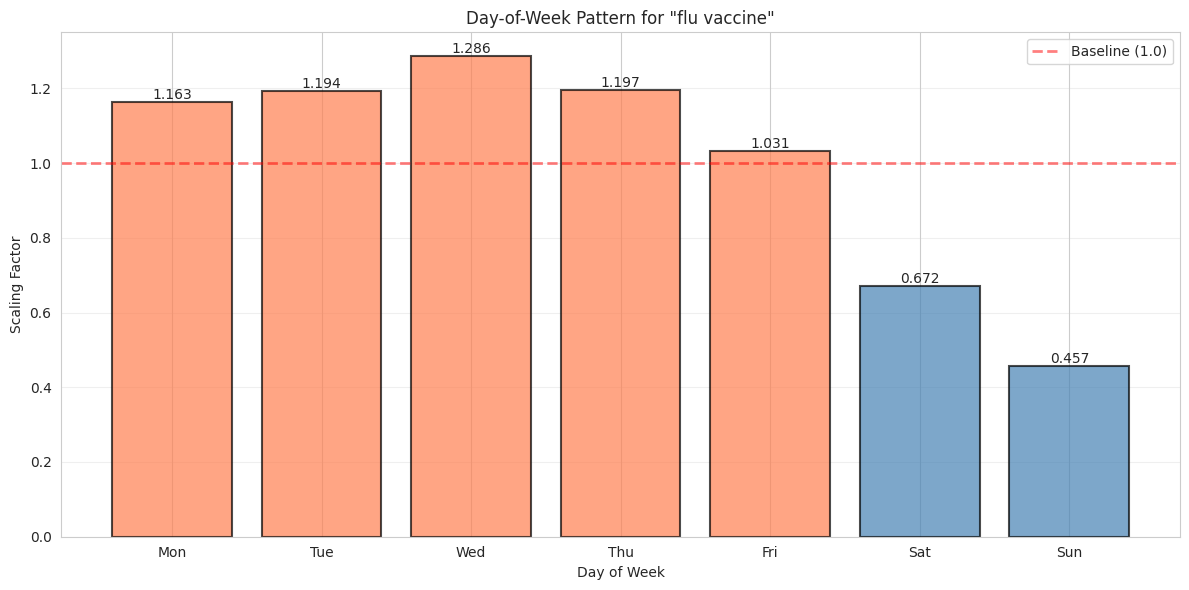


Interpretation:
  - Values > 1.0: Higher activity on that day of the week
  - Values < 1.0: Lower activity on that day of the week
  - If all values ≈ 1.0: No strong weekly pattern detected


In [10]:
# Plot DOW factors
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_values = [dow_factors.get(i, 1.0) for i in range(7)]

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['steelblue' if v < 1 else 'coral' for v in dow_values]
bars = ax.bar(dow_names, dow_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline (1.0)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Scaling Factor')
ax.set_title(f'Day-of-Week Pattern for "{config.search_term}"')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, dow_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height,
            f'{value:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Values > 1.0: Higher activity on that day of the week")
print("  - Values < 1.0: Lower activity on that day of the week")
print("  - If all values ≈ 1.0: No strong weekly pattern detected")

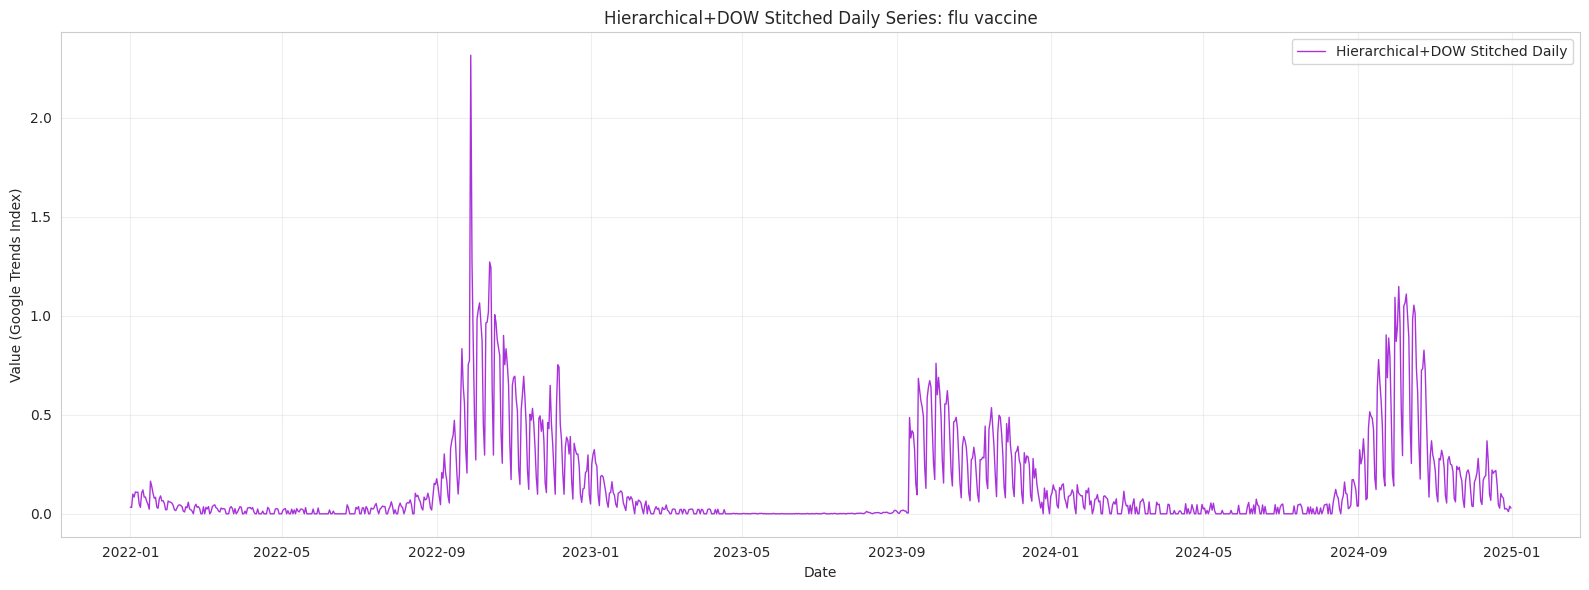

In [11]:
# Plot stitched daily series
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(result.stitched_series['date'], result.stitched_series['value'],
        linewidth=1, alpha=0.8, label='Hierarchical+DOW Stitched Daily', color='darkviolet')
ax.set_xlabel('Date')
ax.set_ylabel('Value (Google Trends Index)')
ax.set_title(f'Hierarchical+DOW Stitched Daily Series: {config.search_term}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

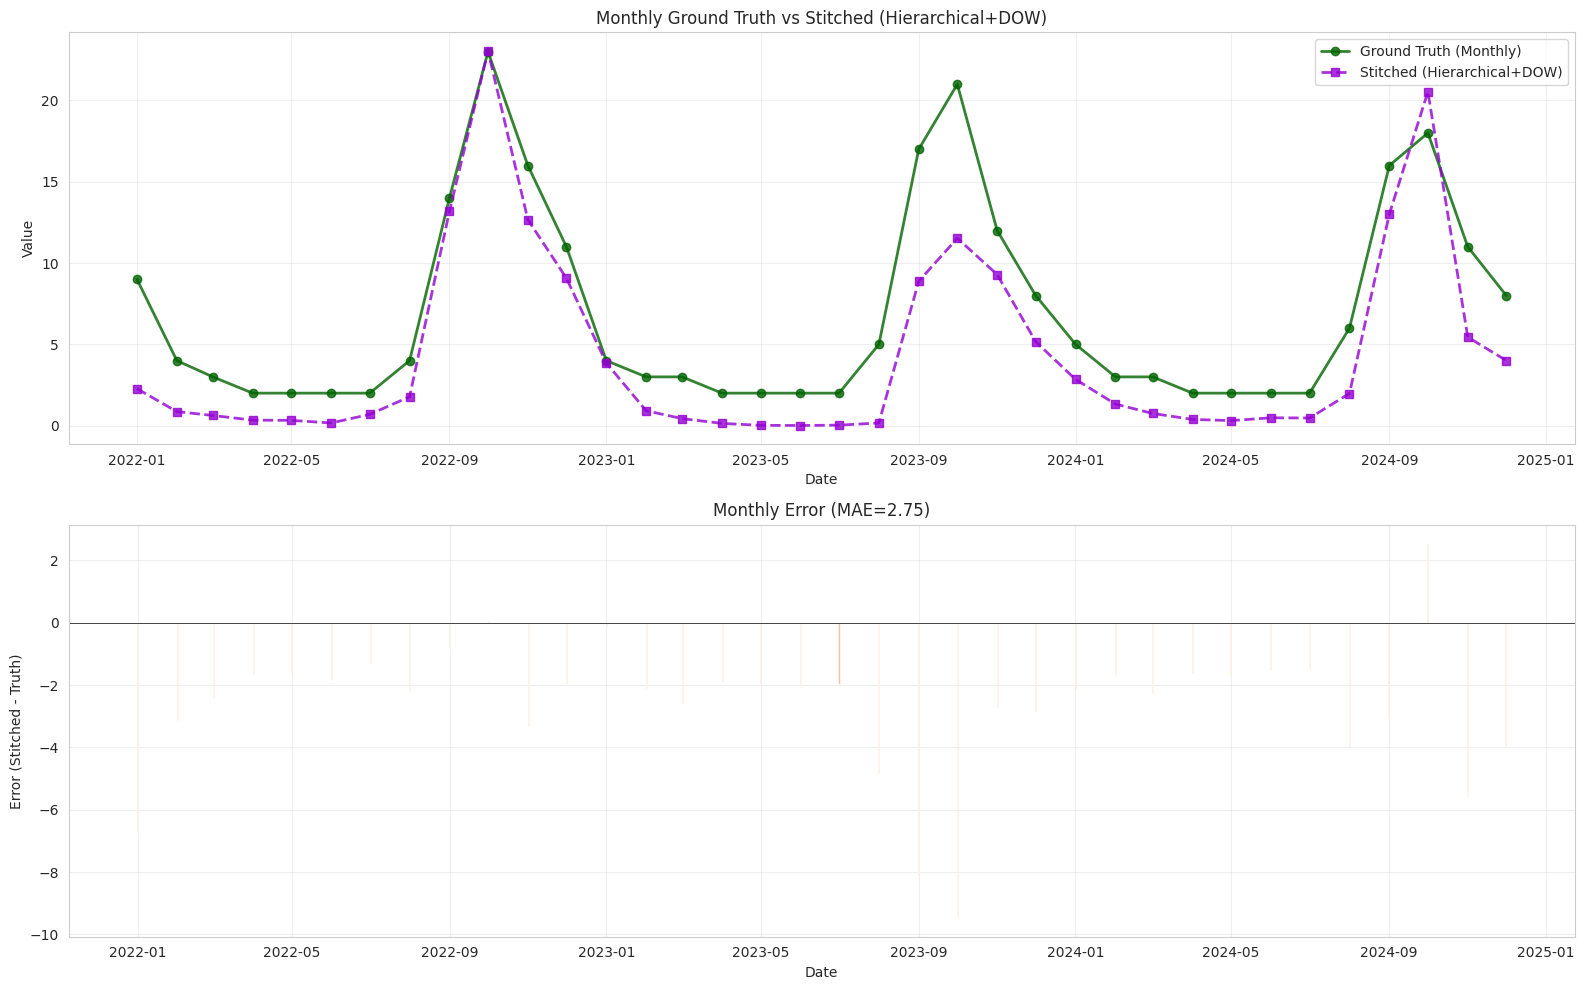

In [12]:
# Plot monthly comparison
if 'monthly_comparison' in result.diagnostics:
    monthly_comp = result.diagnostics['monthly_comparison']

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Actual vs stitched
    axes[0].plot(monthly_comp['date'], monthly_comp['truth'],
                 marker='o', linewidth=2, label='Ground Truth (Monthly)', alpha=0.8, color='darkgreen')
    axes[0].plot(monthly_comp['date'], monthly_comp['stitched'],
                 marker='s', linewidth=2, linestyle='--', label='Stitched (Hierarchical+DOW)', alpha=0.8, color='darkviolet')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Monthly Ground Truth vs Stitched (Hierarchical+DOW)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error plot
    axes[1].bar(monthly_comp['date'], monthly_comp['error'], alpha=0.7, color='coral')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Error (Stitched - Truth)')
    axes[1].set_title(f"Monthly Error (MAE={result.diagnostics['monthly_mae']:.2f})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

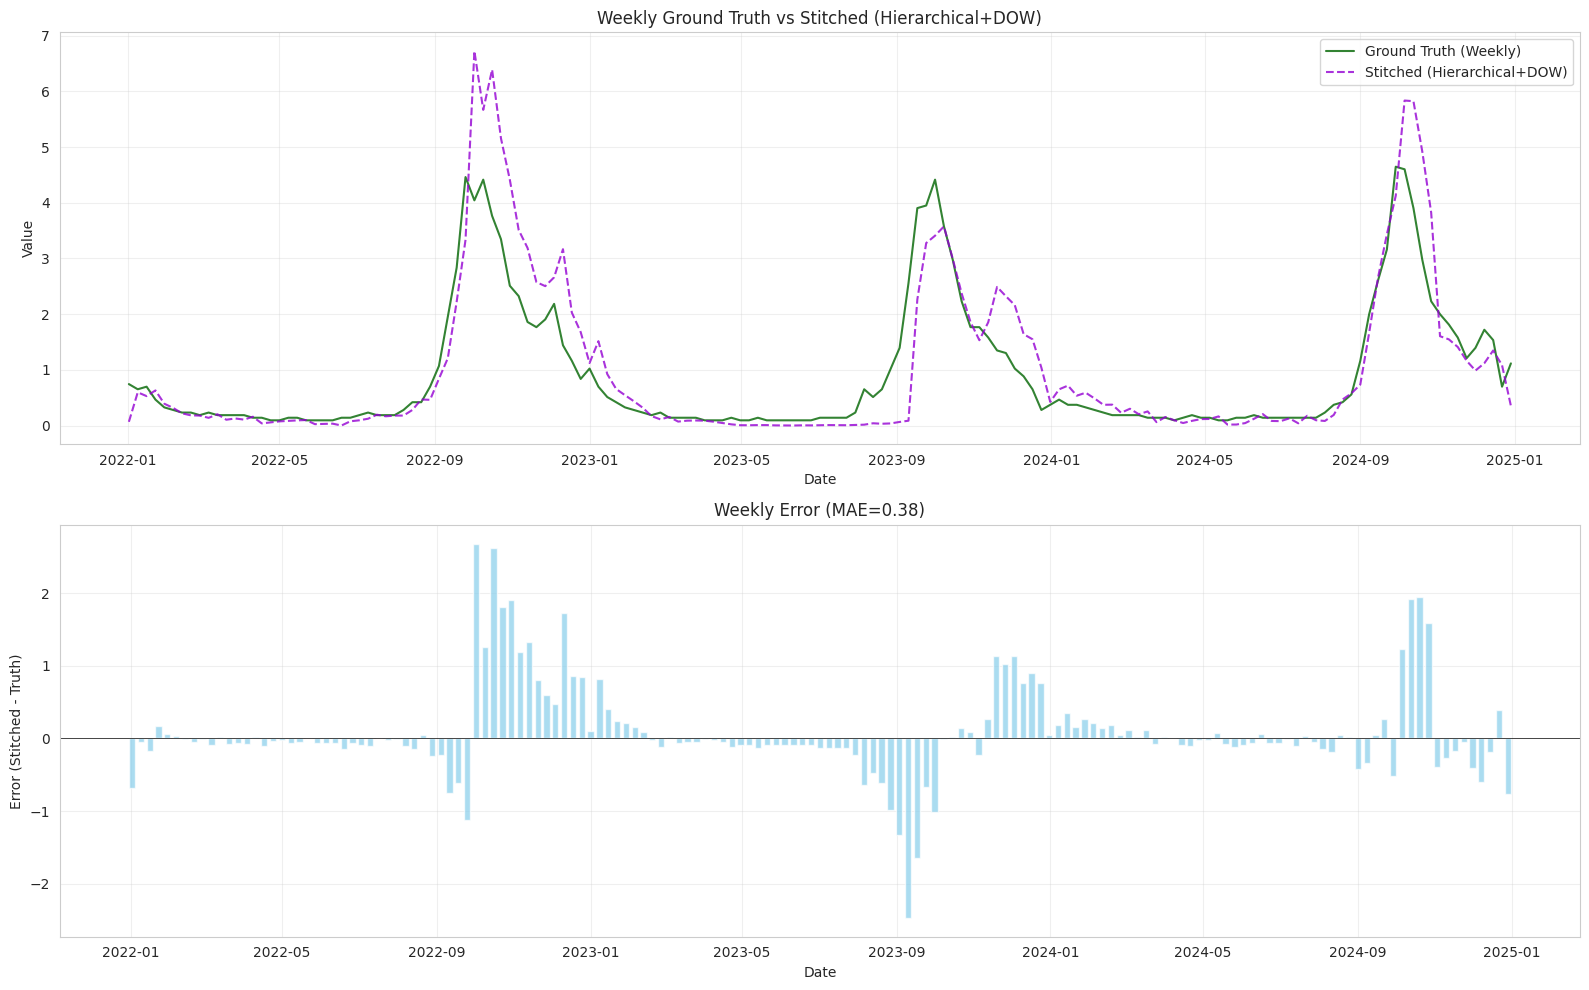

In [13]:
# Plot weekly comparison
if 'weekly_comparison' in result.diagnostics:
    weekly_comp = result.diagnostics['weekly_comparison']

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Actual vs stitched
    axes[0].plot(weekly_comp['date'], weekly_comp['truth'],
                 linewidth=1.5, label='Ground Truth (Weekly)', alpha=0.8, color='darkgreen')
    axes[0].plot(weekly_comp['date'], weekly_comp['stitched'],
                 linewidth=1.5, linestyle='--', label='Stitched (Hierarchical+DOW)', alpha=0.8, color='darkviolet')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Weekly Ground Truth vs Stitched (Hierarchical+DOW)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error plot
    axes[1].bar(weekly_comp['date'], weekly_comp['error'], alpha=0.7, color='skyblue', width=5)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Error (Stitched - Truth)')
    axes[1].set_title(f"Weekly Error (MAE={result.diagnostics['weekly_mae']:.2f})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

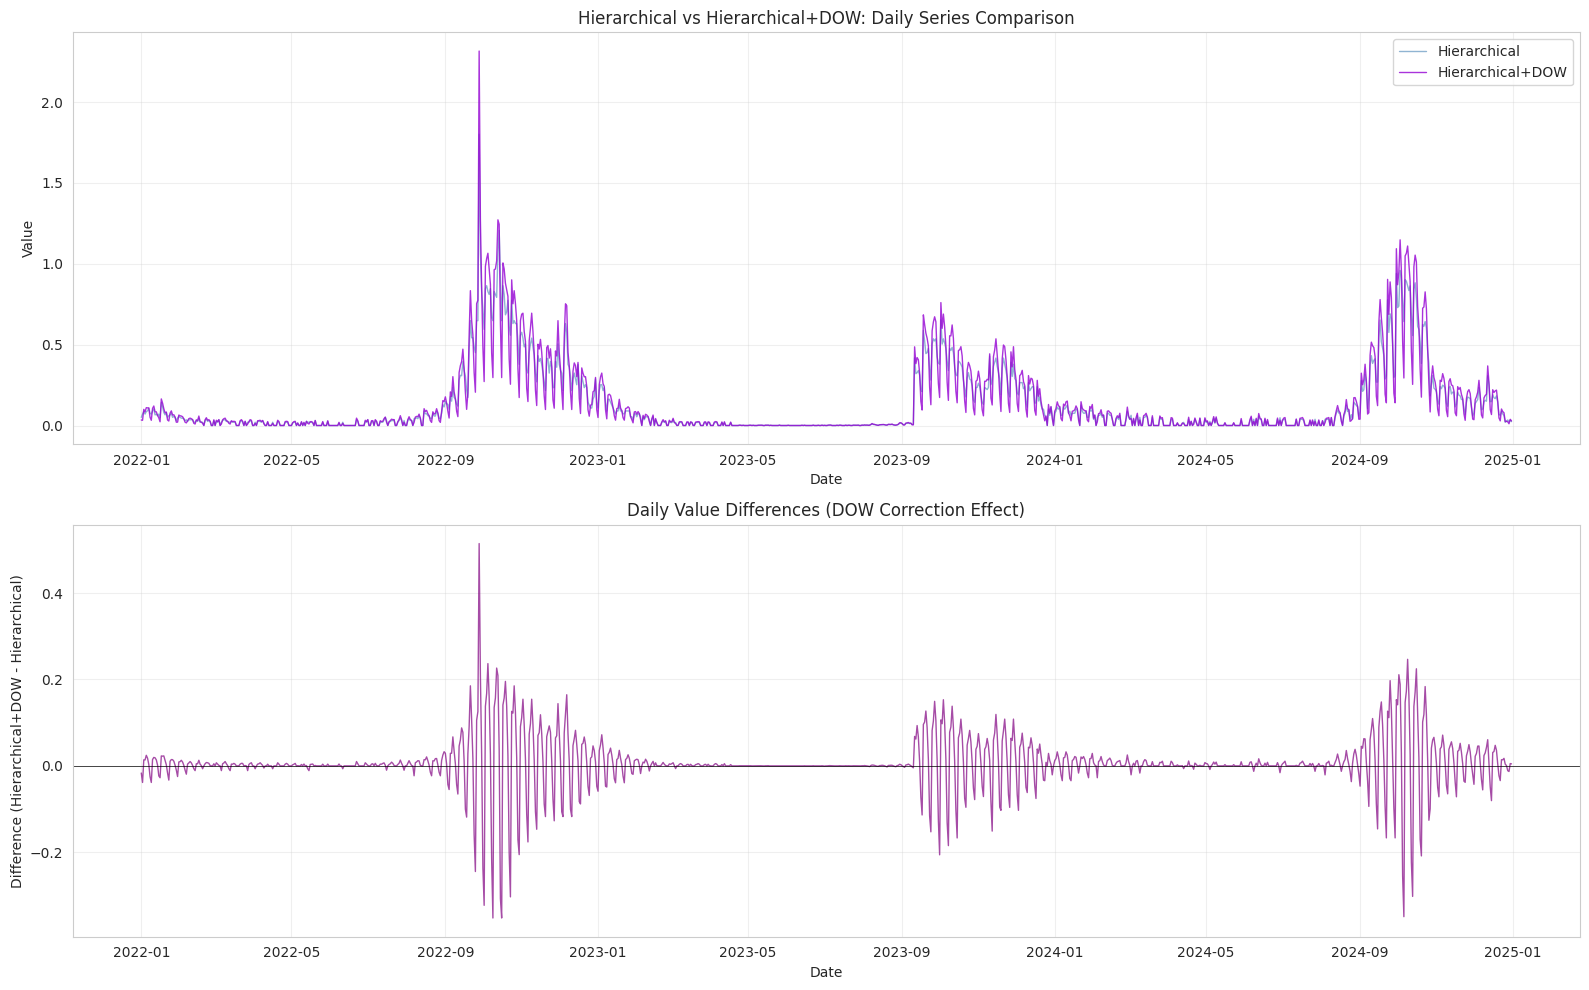

In [14]:
# Compare hierarchical vs hierarchical+DOW (if hierarchical available)
if hierarchical_result is not None:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Daily series comparison
    axes[0].plot(hierarchical_result.stitched_series['date'], hierarchical_result.stitched_series['value'],
                 linewidth=1, alpha=0.6, label='Hierarchical', color='steelblue')
    axes[0].plot(result.stitched_series['date'], result.stitched_series['value'],
                 linewidth=1, alpha=0.8, label='Hierarchical+DOW', color='darkviolet')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Hierarchical vs Hierarchical+DOW: Daily Series Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Difference plot
    merged = pd.merge(
        hierarchical_result.stitched_series.rename(columns={'value': 'hierarchical'}),
        result.stitched_series.rename(columns={'value': 'hierarchical_dow'}),
        on='date',
        how='inner'
    )
    merged['diff'] = merged['hierarchical_dow'] - merged['hierarchical']

    axes[1].plot(merged['date'], merged['diff'], linewidth=1, alpha=0.7, color='purple')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Difference (Hierarchical+DOW - Hierarchical)')
    axes[1].set_title('Daily Value Differences (DOW Correction Effect)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 5. Save Results

In [15]:
# Save results
result.save(file_manager, "hierarchical_dow")
logger.success(f"Results saved to {file_manager.interim / 'hierarchical_dow'}")
print("\n✓ Hierarchical+DOW stitching complete!")

2025-11-12 23:50:51 | INFO     | Saved stitched series to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical_dow/stitched_series.parquet
2025-11-12 23:50:51 | INFO     | Saved alpha estimates to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical_dow/alpha_estimates.pkl
2025-11-12 23:50:51 | INFO     | Saved diagnostics to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical_dow/diagnostics.pkl
2025-11-12 23:50:51 | SUCCESS  | Results saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical_dow



✓ Hierarchical+DOW stitching complete!


## 6. Summary Statistics

In [16]:
# Create summary report
summary = f"""
HIERARCHICAL+DOW STITCHING SUMMARY
===================================

Search Term: {config.search_term}
Date Range: {config.date_range.start} to {config.date_range.end}
Overlap: {config.daily.overlap_days} days

DATA:
  Monthly observations: {len(monthly_data)}
  Weekly observations: {len(weekly_data) if weekly_data is not None else 'N/A'}
  Daily chunks: {len(daily_chunks)}
  Stitched daily points: {len(result.stitched_series)}

DAY-OF-WEEK PATTERN:
"""

dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for dow, name in enumerate(dow_names):
    factor = result.diagnostics['dow_factors'].get(dow, 1.0)
    pct_diff = (factor - 1) * 100
    summary += f"  {name}: {factor:.3f} ({pct_diff:+.1f}%)\n"

summary += f"""
  Mean: {result.diagnostics['dow_mean']:.3f}
  Std: {result.diagnostics['dow_std']:.3f}
  Range: {result.diagnostics['dow_range']:.3f}

VALIDATION METRICS:

  ✅ MONTHLY (DOW-CORRECTED, SOFT CONSTRAINTS - MEANINGFUL):
      MAE: {result.diagnostics.get('monthly_mae', 'N/A'):.2f} (Target: < 3.0)
      RMSE: {result.diagnostics.get('monthly_rmse', 'N/A'):.2f}
"""

if 'monthly_corr' in result.diagnostics:
    summary += f"      Correlation: {result.diagnostics['monthly_corr']:.3f}\n"
if 'monthly_nmae' in result.diagnostics:
    summary += f"      NMAE: {result.diagnostics['monthly_nmae']:.3f}\n"
if 'monthly_bias_pct' in result.diagnostics:
    summary += f"      Bias: {result.diagnostics['monthly_bias_pct']:.1f}%\n"

summary += """
      These metrics are meaningful because the method uses DOW correction
      with soft constraints (not forced renormalization).
"""

if 'base_monthly_mae' in result.diagnostics:
    summary += f"""
  Base Monthly MAE (before DOW): {result.diagnostics['base_monthly_mae']:.2f}
  Improvement: {result.diagnostics.get('monthly_improvement_pct', 0):.1f}%
"""

if 'weekly_mae' in result.diagnostics:
    summary += f"""
  ✅ WEEKLY (INDEPENDENT VALIDATION - MEANINGFUL):
      MAE: {result.diagnostics['weekly_mae']:.2f} ⭐ (Target: < 1.5)
      RMSE: {result.diagnostics['weekly_rmse']:.2f}
"""
    if 'weekly_corr' in result.diagnostics:
        summary += f"      Correlation: {result.diagnostics['weekly_corr']:.3f} (pattern similarity)\n"
    if 'weekly_nmae' in result.diagnostics:
        summary += f"      NMAE: {result.diagnostics['weekly_nmae']:.3f} (scale-invariant)\n"
    if 'weekly_bias_pct' in result.diagnostics:
        summary += f"      Bias: {result.diagnostics['weekly_bias_pct']:.1f}% (systematic deviation)\n"

summary += f"""
ALPHA STATISTICS (Chunk-level):
  Mean: {result.diagnostics['alpha_mean']:.3f}
  Std: {result.diagnostics['alpha_std']:.3f}
  Min: {result.diagnostics['alpha_min']:.3f}
  Max: {result.diagnostics['alpha_max']:.3f}
  CV: {result.diagnostics['alpha_cv']:.3f}
"""

# Add optimization info if available (from base hierarchical method)
if 'optimization' in result.diagnostics:
    opt_info = result.diagnostics['optimization']
    summary += f"""
OPTIMIZATION (Base Hierarchical):
  Converged: {opt_info['converged']}
  Iterations: {opt_info['iterations']}
  Reason: {opt_info.get('stop_reason', opt_info.get('reason', 'N/A'))}
"""

print(summary)

# Save summary to file
summary_path = file_manager.get_report_path("hierarchical_dow_summary.txt")
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"\nSummary saved to {summary_path}")


HIERARCHICAL+DOW STITCHING SUMMARY

Search Term: flu vaccine
Date Range: 2022-01-01 to 2024-12-31
Overlap: 60 days

DATA:
  Monthly observations: 263
  Weekly observations: 158
  Daily chunks: 6
  Stitched daily points: 1096

DAY-OF-WEEK PATTERN:
  Monday: 1.163 (+16.3%)
  Tuesday: 1.194 (+19.4%)
  Wednesday: 1.286 (+28.6%)
  Thursday: 1.197 (+19.7%)
  Friday: 1.031 (+3.1%)
  Saturday: 0.672 (-32.8%)
  Sunday: 0.457 (-54.3%)

  Mean: 1.000
  Std: 0.290
  Range: 0.829

VALIDATION METRICS:

  ✅ MONTHLY (DOW-CORRECTED, SOFT CONSTRAINTS - MEANINGFUL):
      MAE: 2.75 (Target: < 3.0)
      RMSE: 3.39
      Correlation: 0.937
      NMAE: 0.395
      Bias: -37.4%

      These metrics are meaningful because the method uses DOW correction
      with soft constraints (not forced renormalization).

  Base Monthly MAE (before DOW): 2.92
  Improvement: 5.8%

  ✅ WEEKLY (INDEPENDENT VALIDATION - MEANINGFUL):
      MAE: 0.38 ⭐ (Target: < 1.5)
      RMSE: 0.67
      Correlation: 0.900 (pattern simila